# Structural Deep Network Embedding

## El grafo

Antes de entrar en la teoría vamos a definir primero los datos con los que vamos a trabajar, y en torno a los cuales gira todo el asunto.

Primero un grafo G, no dirigido y no ponderado, para ir empezando. Este grafo tendra un conjunto de vértices V y otro conjunto de aristas E. Pondremos de ejemplo un grafo con 128 vértices.


In [63]:
import numpy as np
import math
import latexify
import networkx as nx
import matplotlib.pyplot as plt

np.random.seed(0b101010101010)

total_vertices = 25
matriz_adyacencia = np.zeros((total_vertices, total_vertices), dtype=int)

vertices = np.arange(1,total_vertices+1)

for vertice in range(1, total_vertices + 1):
    # Hasta 2 vecinos. Excluimos el 0 para evitar bucles sobre el mismo vértice
    num_vecinos = np.random.randint(1, 3)
    # Muestra de vecinos aleatorios (con el resto de nodos) sin repeticion
    vecinos = np.random.choice([i for i in range(1, total_vertices+1) if i != vertice], num_vecinos, replace=False)
    
    for vecino in vecinos:
        matriz_adyacencia[vertice - 1, vecino - 1] = 1
        # quitar para probar con grafos dirigidos
        matriz_adyacencia[vecino - 1, vertice - 1] = 1
    
aristas = set()
for i in range(total_vertices):
    for j in range(i+1, total_vertices):
        if matriz_adyacencia[i,j] == 1:
            aristas.add((i+1, j+1))

@latexify.expression
def get_aristas(aristas):
    return aristas

get_aristas(aristas)

{(1, 6),
 (1, 23),
 (2, 21),
 (2, 23),
 (3, 22),
 (4, 7),
 (4, 12),
 (4, 16),
 (4, 23),
 (4, 25),
 (5, 20),
 (6, 9),
 (7, 10),
 (7, 16),
 (7, 19),
 (7, 20),
 (8, 13),
 (8, 18),
 (8, 20),
 (9, 17),
 (9, 25),
 (10, 15),
 (11, 14),
 (11, 19),
 (11, 24),
 (13, 18),
 (14, 21),
 (15, 21),
 (15, 22),
 (16, 22),
 (17, 25),
 (19, 20),
 (21, 22),
 (21, 24)}

In [64]:
E = aristas
V = vertices
adj = matriz_adyacencia

G = {
    "edges": E,
    "vertex": V,
    "adjacency": adj
}

G

{'edges': {(1, 6),
  (1, 23),
  (2, 21),
  (2, 23),
  (3, 22),
  (4, 7),
  (4, 12),
  (4, 16),
  (4, 23),
  (4, 25),
  (5, 20),
  (6, 9),
  (7, 10),
  (7, 16),
  (7, 19),
  (7, 20),
  (8, 13),
  (8, 18),
  (8, 20),
  (9, 17),
  (9, 25),
  (10, 15),
  (11, 14),
  (11, 19),
  (11, 24),
  (13, 18),
  (14, 21),
  (15, 21),
  (15, 22),
  (16, 22),
  (17, 25),
  (19, 20),
  (21, 22),
  (21, 24)},
 'vertex': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25]),
 'adjacency': array([[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
         1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
         0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
         1, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
         0, 0,

Su representación descriptiva:


$$G = (V, E)$$

$$V = \begin{align*}
\{&v_{1}, v_{2}, v_{3}, v_{4}, v_{5}, v_{6}, v_{7}, v_{8}, v_{9}, v_{10}, \\
&v_{11}, v_{12}, v_{13}, v_{14}, v_{15}, v_{16}, v_{17}, \\
&v_{18}, v_{19}, v_{20}, v_{21}, v_{22}, v_{23}, v_{24}, v_{25}\}
\end{align*}$$

$$E = \begin{align*}
\{&(v_{1}, v_{6}), (v_{1}, v_{23}), (v_{2}, v_{21}), (v_{2}, v_{23}), (v_{3}, v_{22}), \\
&(v_{4}, v_{7}), (v_{4}, v_{12}), (v_{4}, v_{16}), (v_{4}, v_{23}), (v_{4}, v_{25}), \\
&(v_{5}, v_{20}), (v_{6}, v_{9}), (v_{7}, v_{10}), (v_{7}, v_{16}), (v_{7}, v_{19}), \\
&(v_{7}, v_{20}), (v_{8}, v_{13}), (v_{8}, v_{18}), (v_{8}, v_{20}), (v_{9}, v_{17}), \\
&(v_{9}, v_{25}), (v_{10}, v_{15}), (v_{11}, v_{14}), (v_{11}, v_{19}), (v_{11}, v_{24}), \\
&(v_{13}, v_{18}), (v_{14}, v_{21}), (v_{15}, v_{21}), (v_{15}, v_{22}), (v_{16}, v_{22}), \\
&(v_{17}, v_{25}), (v_{19}, v_{20}), (v_{21}, v_{22}), (v_{21}, v_{24})\}
\end{align*}$$


Gráficamente es como sigue:

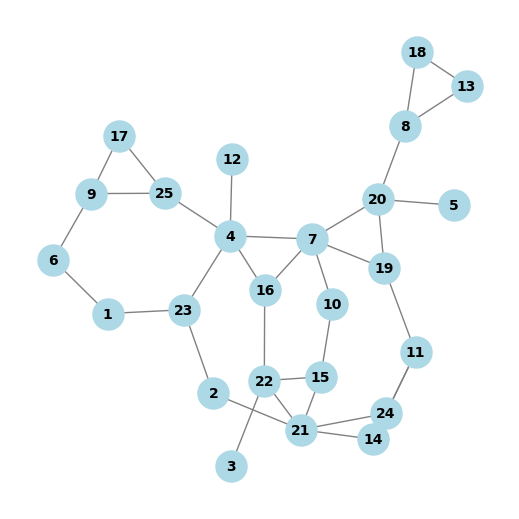

In [65]:
G_nx = nx.Graph()
G_nx.add_edges_from(G.get("edges"))
plt.figure(figsize=(5,5))
pos = nx.kamada_kawai_layout(G_nx, scale=0.2)
nx.draw(G_nx, pos=pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10, font_weight='bold', edge_color='gray')
plt.show()

## Órdenes de un grafo

Ahora que ya tenemos definido el grafo con el que vamos a trabajar, podemos ir a por el siguiente paso.
La red SDNE se basa en un concepto muy importante de la teoría de grafos, que son las proximidades de un vértice.
SDNE toma las siguientes proximidades para incrustar el grafo y mantener su estructura:
* Proximidad de primer orden
* Proximidad de segundo orden

Estas proximidades son en realidad vectores que describen si un par de vértices de un grafo son o no vecinos, es decir, si están conectados mediante una arista).

La proximidad de primer orden entre dos vértices $(v_{i}, v_{j})$ indica si hay una conexión directa entre ambos vértices. Tomemos por ejemplo el nodo $v_3$ del grafo, su vector de proximidad de primer orden será la fila (o columna) de la matriz de adyacencia que relaciona ese nodo con los demás. En el caso de la proximidad de primer orden entre el nodo 3 y el nodo 22, tendremos que $(v_{3}, v_{22}) = 1$.

La proximidad de segundo orden describe cómo de similares son dos vértices basándose en los vectores de proximidad de 1er orden de dichos vértices. Vamos a explicar esto con un ejemplo. Tomemos los vectores de proximidad de los vectores $v_23$ y $v_21$, denotados por $N_3$ y $N_21$. Sus vectores de proximidad de primer orden son los siguientes:

$$
\begin{align*}
&N_3 =  \{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,\} \\
&N_{21} = \{0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,0,\}
\end{align*}
$$

La proximidad de segundo orden queda reducida a la similaridad de estos dos vectores. Observamos, en este caso, que ambos vértices comparten como vecino el vértice 22. Quizás una manera de obtener la proximidad de segund orden como un único vector sea la intersección de ambos vectores, de manera que $N_{3,21} = N_3 \cap N_{21} = \{0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,\}$


## El problema

Lo que SDNE intenta solucionar es __APRENDER__ una función de incrustación $f$ (_embedding_) para representar un grafo $G$ en un espacio con baja dimensionalidad, de tal forma que:
$$
f: v_i \mapsto y_i \in {R^d}
$$

Donde $v_i \mapsto y_i$ es el mapeo de cada vértice a un vector de longitud $d$. Y siendo $d$ menor que el número de vértices: $d \ll |V|$

Como se explica en el _paper_, el objetivo es conseguir que la similaridad de los vectores reducidos de cada par de vértices ($y_i,y_j$) mantenga las proximidades de primer y segundo orden entre dichos vértices ($v_i,v_j$)

## La red

Ya hemos explicado las bases. Ahora vamos con la red en sí.

Como muchas redes neuronales de grafos (GNN), y más en específico en el ámbito de la incrustación de grafos, la red SDNE tiene un autoencoder (encoder+decoder).

El _encoder_ está formado por varias capas, cuyas funciones son lineales. La función de cada capa del _encoder_ se describe de la siguiente forma:

$$
\begin{align}
&y^{(1)}_i = \sigma(W^{(1)} x_i + b^{(1)})\\
&y^{(k)}_i = \sigma(W^{(k)} y^{(k-1)}_i + b^{(k)})
\end{align}
$$

Siendo $k$ la capa actual, $W$ los pesos de la capa $k$, y $b$ el sesgo, ambos como parámetros de aprendizaje. La función lineal $y=W·x+b$ pasa a su vez por una función sigmoidea como función de activación para la red, $\sigma(y) = \frac{1}{1+exp(-y)}$


Si tenemos $K$ capas en el encoder, el resultado de la capa de salida será $y^{(K)}_i$. Si realizamos los cálculos inversos del encoder, haciendo uso de un decoder, podremos reconstruir (de forma aproximada) la entrada, a la que llamaremos $\hat{x_i}$. Para ayudar a disipar la confusión, a partir de ahora, cualquier símbolo o parámetro representado con ^ es el equivalente en el decoder.

Ahora, con las salidas del decoder y del encoder por igual, podemos la función de pérdida del _autoencoder_ como un conjunto. La función de pérdida se define como:

$$
\mathcal{L} = \sum_{i=1}^{n} ||\hat{x_i} - x_i ||^2_2
$$

Dicho de otra forma, es el sumatorio de todas las salidas del autoencoder (grafo embebido y luego reconstruido) en forma de norma euclídea. Simplemente el cuadrado del error entre el valor predicho por la red del autoencoder $\hat{x_i}$ y el valor real $x_i$. En estadística y en la literatura del aprendizaje automático se conoce como error cuadrático medio, donde se usa frecuentemente.

Pero hay un problema, que los grafos al ser generalmente dispersos, el _autoencoder_ representará mejor la ausencia de conexión entre dos vértices que la conexión entre estos. Para paliar esto, en SDNE, la función de pérdida es una modificación de la primera que incluye el producto de Hadamard de matrices. Antes de seguir quiero indicar que este producto es simplemente la multiplicación de cada elemento de una matriz por otra, ambas con las mismas dimensiones, y donde el producto es una matriz con las mismas dimensiones que las primeras. Esta operación se representa por el símbolo $\odot$